In [8]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [9]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=True)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [10]:
# pf.session.load_data(name='hospital', src=FILE, fpath='data/hospital_clean_unflatten.csv', check_param=True, na_values='empty')
pf.session.load_data(name='forestfire', src=FILE, fpath='forestfires/forestfires-enhanced-20-dirty.csv', check_param=True, na_values='empty')

INFO:profiler.utility:[2.5177159309387207] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': 'empty', 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "0": "numeric",
    "1": "numeric",
    "2": "categorical",
    "3": "categorical",
    "4": "numeric",
    "5": "numeric",
    "6": "numeric",
    "7": "text",
    "8": "numeric",
    "9": "numeric",
    "10": "numeric",
    "11": "numeric",
    "12": "categorical"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'0': ['equal'], '1': ['equal'], '2': ['equal'], '3': ['equal'], '4': ['equal'], '5': ['equal'], '6': ['equal'], '7': ['equal'], '8': ['equal'], '9': ['equal'], '10': ['equal'], '11': ['equal'], '12': ['equal']}
INFO:profiler.data.dataset:(pos

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [4]:
# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample','HospitalType','HospitalOwner', 'Condition'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC, TEXT,TEXT, TEXT],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients', None, None,None])

INFO:profiler.data.dataset:updated types of ProviderNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of ProviderNumber to ['equal']
INFO:profiler.data.dataset:updated types of ZipCode to 'numeric'
INFO:profiler.data.dataset:updated operators of ZipCode to ['equal']
INFO:profiler.data.dataset:updated types of PhoneNumber to 'categorical'
INFO:profiler.data.dataset:updated operators of PhoneNumber to ['equal']
INFO:profiler.data.dataset:updated types of State to 'text'
INFO:profiler.data.dataset:updated operators of State to ['equal']
INFO:profiler.data.dataset:updated types of EmergencyService to 'text'
INFO:profiler.data.dataset:updated operators of EmergencyService to ['equal']
INFO:profiler.data.dataset:updated types of Score to 'numeric'
INFO:profiler.data.dataset:updated operators of Score to ['equal']
INFO:profiler.data.dataset:updated types of Sample to 'numeric'
INFO:profiler.data.dataset:updated operators of Sample to ['equal']
INFO:profiler.data.dataset:upd

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [11]:
pf.session.load_embedding(save=True, path='data/', load=False)

INFO:profiler.utility:[9.626137495040894] Load Embedding start

INFO:profiler.data.embedding:[7] tokenize cell
INFO:profiler.data.embedding:[7] train language model
INFO:profiler.data.embedding:[7] compute weights
INFO:profiler.data.embedding:[7] create vector map
INFO:profiler.data.embedding:[7] save vec and vocab
INFO:profiler.utility:[14.783835172653198] Load Embedding execution time: 5.157697677612305



## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [12]:
# use simple empirical cov: difference=False
# use difference -> cov : difference=True
pf.session.load_training_data(multiplier = None, difference=True)

INFO:profiler.utility:[17.02124834060669] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 2 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 2, and the bound is 0.00076830
INFO:profiler.data.transformer:Using multiplier 5
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 13/13 [00:00<00:00, 146.18it/s]
INFO:profiler.data.transformer:Number of training samples: 78000
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[17.80699396133423] Create Training Data execution time: 0.7857456207275391



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [13]:
# set sparsity to 0 for exp_reproduce 
autoregress_matrix = pf.session.learn_structure(sparsity=0, infer_order=True)

INFO:profiler.utility:[20.692824363708496] Learn Structure start

INFO:profiler.learner:use threshold 0.4332
INFO:profiler.utility:[20.88995862007141] Learn Structure execution time: 0.19713425636291504



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [14]:
parent_sets = pf.session.get_dependencies(score="fit_error")

INFO:profiler.utility:[23.90474820137024] Get Dependencies start

INFO:profiler.utility:[24.021968603134155] Get Dependencies execution time: 0.11722040176391602



2 -> 3 (0.19204991430914364)
3 -> 5 (0.2006871511602104)
2,5 -> 0 (0.16570755595606818)
2,5,0 -> 1 (0.09504071876472928)
3,5,0,1 -> 6 (0.09921739567919313)
2,3,6 -> 7 (0.10822646940217272)
2,3,5,1,6 -> 8 (0.08505094182068303)
2,3,5,0,1,6 -> 10 (0.23662740836111437)
2,3,5,0,1,6,7,8,10 -> 12 (0.04763612489675546)
5,12 -> 4 (0.07240507936775274)
2,1,6,8,12 -> 11 (0.03913384330584289)
5,8,12,4,11 -> 9 (0.12214457935033574)
{'2': array([], dtype=object), '3': array(['2'], dtype=object), '5': array(['3'], dtype=object), '0': array(['2', '5'], dtype=object), '1': array(['2', '5', '0'], dtype=object), '6': array(['3', '5', '0', '1'], dtype=object), '7': array(['2', '3', '6'], dtype=object), '8': array(['2', '3', '5', '1', '6'], dtype=object), '10': array(['2', '3', '5', '0', '1', '6'], dtype=object), '12': array(['2', '3', '5', '0', '1', '6', '7', '8', '10'], dtype=object), '4': array(['5', '12'], dtype=object), '11': array(['2', '1', '6', '8', '12'], dtype=object), '9': array(['5', '8', '12',

In [9]:
import os, json
def read_fds(path='data/fds', f='TECHospital-hyfd'):
    all_fds = {}
    for line in open(os.path.join(path,f)):
        fd = json.loads(line)
        right = fd[u'dependant']['columnIdentifier']
        left = [l[u'columnIdentifier'] for l in fd[ u'determinant'][u'columnIdentifiers']]
        if right not in all_fds:
            all_fds[right] = set()
        all_fds[right].add(frozenset(left))
    return all_fds

In [10]:
gt = read_fds(f='hospital_clean-fun')

In [11]:
tp = 0
count = 0
for child in parent_sets:
    found = parent_sets[child]
    if len(found) == 0:
        continue
    count += 1
    match = False
    for parent in gt[child]:
        if set(parent).issubset(found):
            tp += 1
            match = True
            break
    if not match:
        print("{} -> {} is not valid".format(found, child))
if count > 0:
    print("Precision: %.4f"%(float(tp) / count))

['HospitalOwner'] -> ZipCode is not valid
['HospitalType' 'State'] -> Stateavg is not valid
['ZipCode' 'State' 'MeasureName'] -> Sample is not valid
['HospitalType' 'Stateavg'] -> Score is not valid
Precision: 0.7500


## 5. Visualization

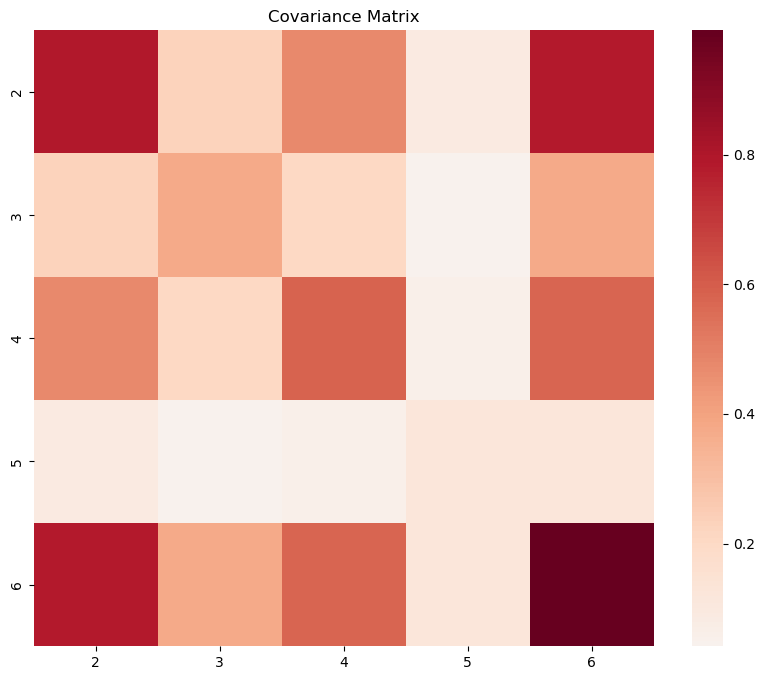

In [15]:
pf.session.visualize_covariance()

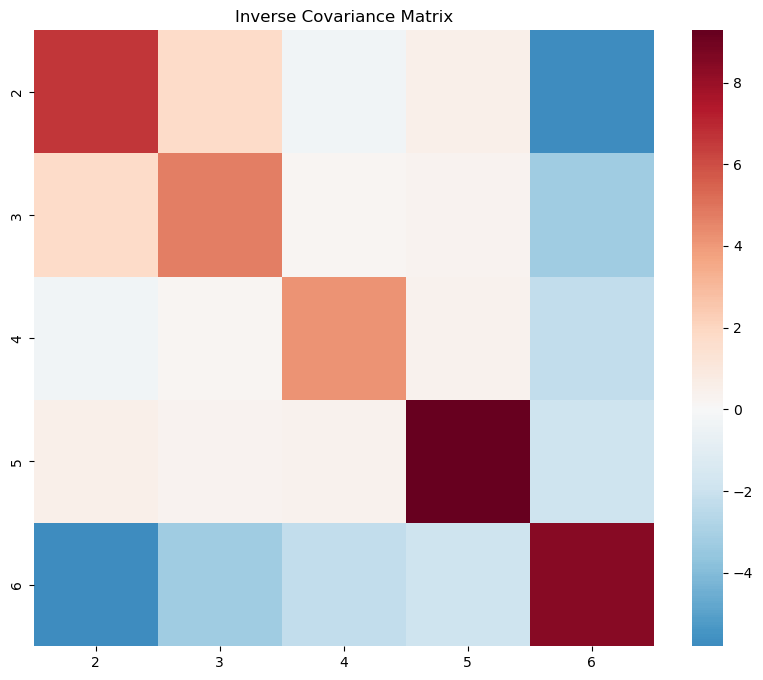

In [16]:
pf.session.visualize_inverse_covariance()

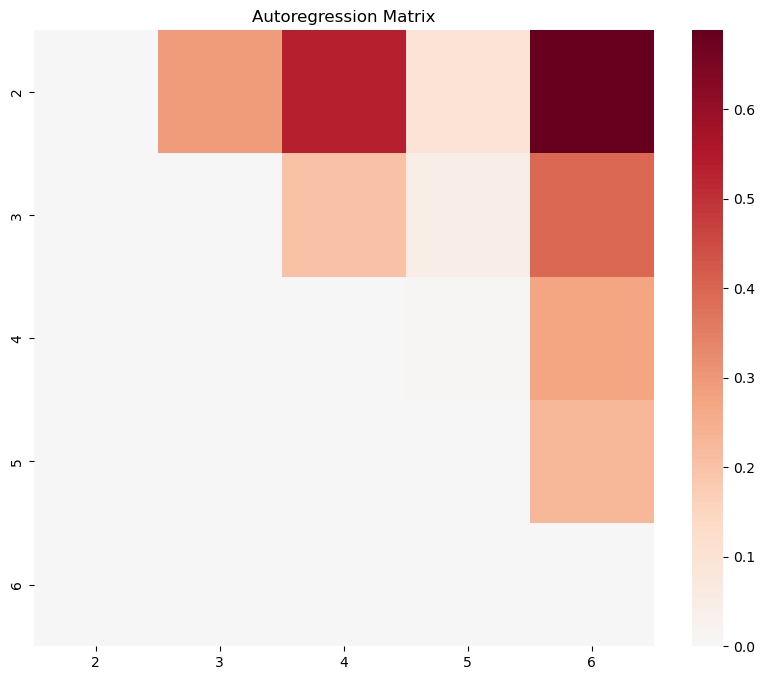

In [17]:
pf.session.visualize_autoregression()

In [15]:
pf.session.timer.get_stat()

time_point                          msg  execution_time
0     2.517716             start: Load Data        0.000000
1     2.637632               end: Load Data        0.119916
2     9.626137        start: Load Embedding        0.000000
3    14.783835          end: Load Embedding        5.157698
4    17.021248  start: Create Training Data        0.000000
5    17.806994    end: Create Training Data        0.785746
6    20.692824       start: Learn Structure        0.000000
7    20.889959         end: Learn Structure        0.197134
8    23.904748      start: Get Dependencies        0.000000
9    24.021969        end: Get Dependencies        0.117220
10   24.021969         total_execution_time        6.377714

In [16]:
pf.session.timer.to_csv()